In [1]:
#Imports
import nltk
import networkx as nx
import pandas as pd
import os
from nltk.corpus import PlaintextCorpusReader, stopwords
import os
import string
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize
nltk.download('punkt')

### Initial Processing of "Game of Thrones" Script Data

This section covers the initial steps of handling the "Game of Thrones" script data. We begin by loading the data from a CSV file, then group and tokenize the script for each episode. This prepares the data for subsequent sentiment analysis.


In [2]:
# Read the CSV file
got_data = pd.read_csv("Game_of_Thrones_Script.csv", delimiter=';')

# Combine the sentences for each episode
grouped_data = got_data.groupby(['Season', 'Episode'])['Sentence'].apply(' '.join).reset_index()

# Tokenize the text for each episode
grouped_data['Tokenized Sentences'] = grouped_data['Sentence'].apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asger\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Refining Text Data for Analysis

This section involves enhancing the script data by filtering out commonly used words that are less significant for text analysis. This step streamlines the dataset, ensuring that the focus remains on the more impactful words in each episode's script.


In [3]:
# Function to remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# Remove stopwords
grouped_data['Cleaned Tokens'] = grouped_data['Tokenized Sentences'].apply(remove_stopwords)

### Analyzing Episode Sentiments

In this section, we apply sentiment analysis to the cleaned script data of each "Game of Thrones" episode. The outcome is a set of sentiment scores, reflecting the overall emotional tone of the dialogue in each episode.


In [4]:
def parse_txt(filepath="pone.0026752.s001.txt"):
    word_data = {}
    with open(filepath, 'r') as file:
        next(file)  # skip the header
        for line in file:
            parts = line.split('\t')
            if len(parts) < 3:  # Ensure there are enough parts in the line
                continue
            word = parts[0]
            try:
                happiness_avg = float(parts[2])
                word_data[word] = happiness_avg
            except ValueError:  # Handle cases where the value isn't a float
                continue
    return word_data

word_data = parse_txt()

# Functions for sentiment analysis
def sentiment_score_per_file(tokens_dict, word_data):
    scores = {}
    for file_name, tokens in tokens_dict.items():
        scores[file_name] = sentiment_score(tokens, word_data)
    return scores

def sentiment_score(tokens, word_data):
    nominator = 0
    denominator = 0
    for token in tokens:
        if token not in word_data:
            continue
        else:
            frequency = tokens.count(token)
            nominator += (word_data[token]*frequency)
            denominator += frequency
    return nominator/denominator if denominator != 0 else 0

# Prepare data for sentiment analysis
tokens_dict = grouped_data.set_index(['Season', 'Episode'])['Cleaned Tokens'].to_dict()

# Calculate sentiment scores
episode_scores = sentiment_score_per_file(tokens_dict, word_data)

# Display sentiment scores
print(episode_scores)


{('Season 1', 'Episode 1'): 5.36409989122552, ('Season 1', 'Episode 10'): 5.335616222896313, ('Season 1', 'Episode 2'): 5.322585593823021, ('Season 1', 'Episode 3'): 5.320838154088872, ('Season 1', 'Episode 4'): 5.330167546336064, ('Season 1', 'Episode 5'): 5.401869913686801, ('Season 1', 'Episode 6'): 5.3818146820655715, ('Season 1', 'Episode 7'): 5.49347474747475, ('Season 1', 'Episode 8'): 5.519390635022454, ('Season 1', 'Episode 9'): 5.335709352275604, ('Season 2', 'Episode 1'): 5.4416006387347, ('Season 2', 'Episode 10'): 5.579943755858773, ('Season 2', 'Episode 2'): 5.375435114503784, ('Season 2', 'Episode 3'): 5.403187599364083, ('Season 2', 'Episode 4'): 5.476604530183168, ('Season 2', 'Episode 5'): 5.347080811298693, ('Season 2', 'Episode 6'): 5.470627126436778, ('Season 2', 'Episode 7'): 5.457759865423692, ('Season 2', 'Episode 8'): 5.353886843744674, ('Season 2', 'Episode 9'): 5.369143724257524, ('Season 3', 'Episode 1'): 5.408645926812239, ('Season 3', 'Episode 10'): 5.3153

### Organizing Sentiment Scores into a DataFrame

In this part, the sentiment scores for each "Game of Thrones" episode are organized into a DataFrame for easier analysis and visualization. The episodes are sorted by season and episode number, facilitating a structured overview of the sentiment trends across the series.

In [7]:
# Convert the dictionary to a DataFrame
episode_list = [f"{season} {episode}" for season, episode in episode_scores.keys()]
score_list = list(episode_scores.values())
score_df = pd.DataFrame({'Episode': episode_list, 'Score': score_list})

# Extract numerical parts for sorting
score_df['Season_Number'] = score_df['Episode'].apply(lambda x: int(x.split(' ')[1]))
score_df['Episode_Number'] = score_df['Episode'].apply(lambda x: int(x.split(' ')[3]))

# Sort by season and episode number
score_df.sort_values(by=['Season_Number', 'Episode_Number'], inplace=True)

### Advanced Sentiment Analysis and Visualization

This segment focuses on an advanced level of sentiment analysis for "Game of Thrones" episodes. We perform a statistical comparison of each episode's sentiment score against a distribution of randomly sampled scores. This helps in identifying episodes with significantly higher or lower sentiment than average. The results are then visually represented in a histogram, color-coded to highlight episodes that stand out in terms of their emotional tone.


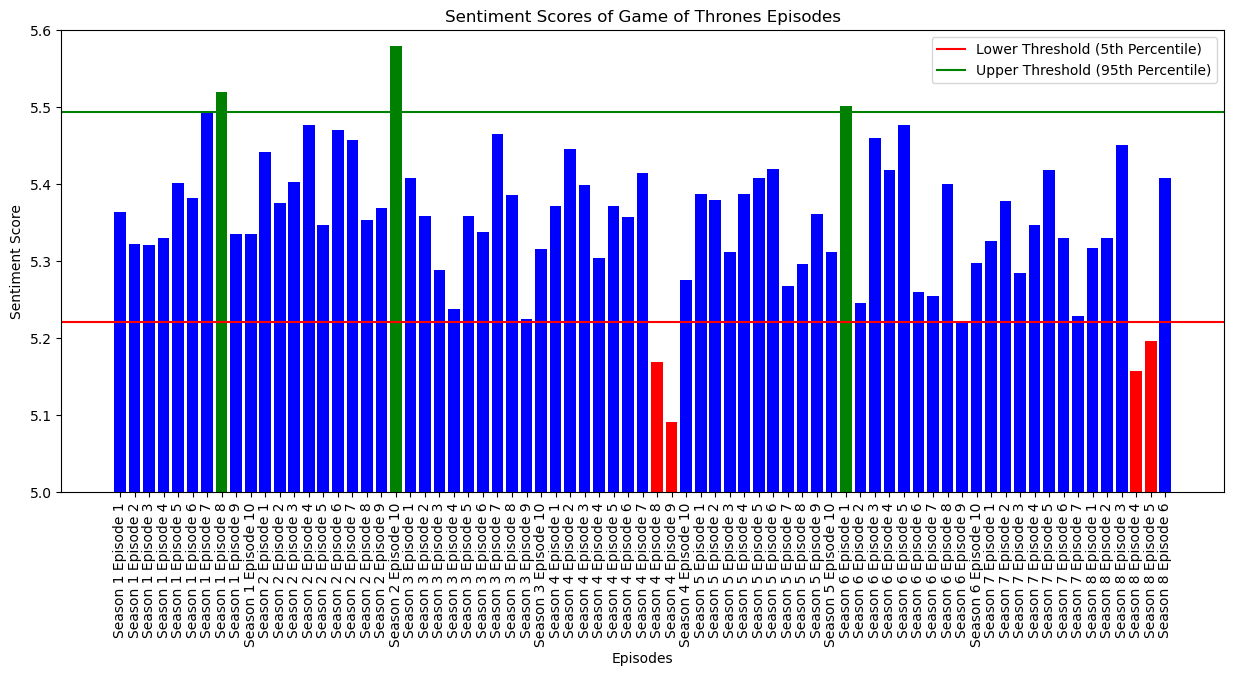

In [8]:
def sentiment_analysis(episode_scores, specific_episode_score, shuffled_means, num_iterations):

    count_lower = sum(1 for mean in shuffled_means if mean < specific_episode_score)
    count_higher = sum(1 for mean in shuffled_means if mean > specific_episode_score)

    proportion_lower = count_lower / num_iterations
    proportion_higher = count_higher / num_iterations

    if proportion_lower < 0.05:
        result = "Lower"
    elif proportion_higher < 0.05:
        result = "Higher"
    else:
        result = "Insignificant"

    return {
        'specific_episode_score': specific_episode_score,
        'proportion_lower': proportion_lower,
        'proportion_higher': proportion_higher,
        'result': result
    }

all_scores = list(episode_scores.values())
num_episodes = 1  # Since we are analyzing one episode at a time
num_iterations = 10000
shuffled_means = []
for _ in range(num_iterations):
    random_sample = np.random.choice(all_scores, size=num_episodes, replace=False)
    shuffled_means.append(np.mean(random_sample))

# Apply the function to each episode
analysis_results = {}
for episode, score in episode_scores.items():
    analysis_results[episode] = sentiment_analysis(episode_scores, score, shuffled_means, num_iterations)


# Convert the results to a DataFrame
analysis_results_df = pd.DataFrame(analysis_results).transpose()

# Calculate thresholds
lower_threshold = np.percentile(shuffled_means, 5)
upper_threshold = np.percentile(shuffled_means, 95)

# Determine the color for each bar based on whether it falls within the thresholds
colors = ['red' if (score < lower_threshold) else 'green' if (score > upper_threshold) else 'blue' for score in score_df['Score']]

# Make a histogram with episodes on the x-axis and sentiment scores on the y-axis
plt.figure(figsize=(15, 6))
plt.bar(score_df['Episode'], score_df['Score'], color=colors)
plt.xlabel('Episodes')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores of Game of Thrones Episodes')

# Adding horizontal lines for the thresholds
plt.axhline(y=lower_threshold, color='r', linestyle='-', label='Lower Threshold (5th Percentile)')
plt.axhline(y=upper_threshold, color='g', linestyle='-', label='Upper Threshold (95th Percentile)')

plt.xticks(rotation=90)  # Rotates the x-axis labels for readability
plt.ylim(5, 5.6)  # Set the y-axis limits
plt.legend()  # Add a legend to display labels
plt.show()

### Conclusion: Sentiment Trends in "Game of Thrones"

The histogram, highlighting episodes with statistically significant sentiment scores, indicates that most episodes do not deviate markedly from the average sentiment of the series. However, there are notable exceptions, such as Season 1 Episode 8, Season 2 Episode 10, and Season 6 Episode 1, which exhibit a higher sentiment, and Season 4 Episodes 8 and 9, Season 8 Episode 4, and Season 4 Episode 5, which display a lower sentiment. These findings suggest that while the series maintains a relatively consistent emotional tone, certain episodes stand out for their particularly heightened or subdued sentiments. we can say with 95% confidence that the sentiment scores falling outside the 5th and 95th percentiles of the average score, are not just due to random chance. However, it is also obvious that these scores all fall between 5 and 6 in sentiment score, which is a very neutral.

